In [1]:
import numpy as np
import scipy.stats as st

import matplotlib.pyplot as plt

import reliable_conformal_prediction as rcp

In [2]:
# Parameters
N_MC_SIMULATIONS = 100000 # Number of Monte Carlo simulations
N = 100 # Calibration set size

cnom = 0.9 # Nominal coverage (for classic conformal prediction)
CONF = 0.95 # Confidence level for the new guarantee

rng = np.random.default_rng(1234) # Random number generator seed (for reproducibility)
error_dist = st.foldnorm(c=0) # We assume the error distribution is a folded normal
error = error_dist.rvs(size=(N_MC_SIMULATIONS, N), random_state=rng) # Sample of errors

In [ ]:
unconf_q = 0 # We use a null model as base (unconformalized)
scores = error[:, :N] - unconf_q # Nonconformity scores for the null model

# Classic conformal prediction
cp_qlevel = np.clip(np.ceil((N+1)*cnom)/N, 0, 1) # Classic CP quantile level
qhat_cp = np.quantile(scores, cp_qlevel, axis=1, method="inverted_cdf")
cp_q = unconf_q + qhat_cp
cp_cov = error_dist.cdf(cp_q) # Coverage of classic CP

# New guarantee (Reliable Conformal Prediction)
new_qlevel = rcp.get_quantile(n=N, min_cov=cnom, conf=CONF) # New guarantee quantile level
qhat_ncp = np.quantile(scores, new_qlevel, axis=1, method="inverted_cdf")
ncp_q = unconf_q + qhat_ncp
ncp_cov = error_dist.cdf(ncp_q) # Coverage of new guarantee

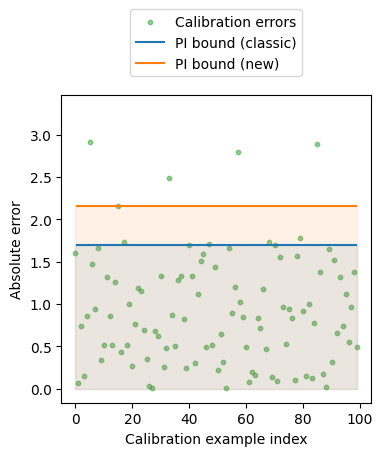

In [4]:
sim_idx = 0

fig, axs = plt.subplots(figsize=(4,4))

axs.scatter(np.arange(N), error[sim_idx, :N], color="tab:green", alpha=0.5, label="Calibration errors", s=10)

axs.axhline(cp_q[sim_idx], xmin=0.05, xmax=0.95, color="tab:blue", linestyle="-", label="PI bound (classic)")
axs.fill_between(np.arange(N), np.zeros(N), np.ones(N) * cp_q[sim_idx], color="tab:blue", alpha=0.1)

axs.axhline(ncp_q[sim_idx], xmin=0.05, xmax=0.95, color="tab:orange", linestyle="-", label="PI bound (new)")
axs.fill_between(np.arange(N), np.zeros(N), np.ones(N) * ncp_q[sim_idx], color="tab:orange", alpha=0.1)

axs.set_xlabel("Calibration example index")
axs.set_ylabel("Absolute error")

axs.set_ylim([-0.165, 3.473])

axs.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3))

plt.show()

Cmin with 0.95 confidence using the new guarantee: 0.9110522940632496
Cmin with 0.95 confidence using the classic guarantee: 0.8482863320447966


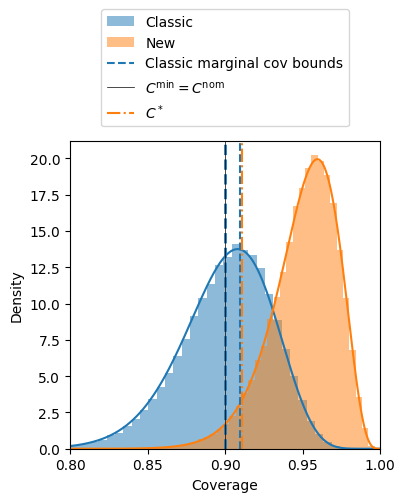

In [5]:
print(f"Cmin with {CONF} confidence using the new guarantee: {np.quantile(ncp_cov, 1-CONF)}")
print(f"Cmin with {CONF} confidence using the classic guarantee: {np.quantile(cp_cov, 1-CONF)}")

xlims = [0.8, 1]
x_space = np.linspace(xlims[0], xlims[1], 1000)

fig, axs = plt.subplots(figsize=(4,4))

axs.plot(x_space, st.beta.pdf(x_space, a=(N+1)*cnom, b=(N+1)*(1-cnom)), color='tab:blue', linestyle='-', linewidth=1.5)
axs.hist(cp_cov, bins=50, alpha=0.5, label='Classic', color='tab:blue', density=True)

m = np.ceil(N*new_qlevel)
cov_dist = st.beta(m, N-m+1)
axs.plot(x_space, cov_dist.pdf(x_space), color='tab:orange', linestyle='-', linewidth=1.5)
axs.hist(ncp_cov, bins=50, alpha=0.5, label='New', color='tab:orange', density=True)

axs.axvline(cnom, color="tab:blue", linestyle="--", linewidth=2)
axs.axvline(cnom+1/(N+1), color="tab:blue", linestyle="--", label="Classic marginal cov bounds")

axs.axvline(cnom, color="k", linestyle="-", label="$C^\\text{min} = C^\\text{nom}$", linewidth=0.5)
axs.axvline(np.quantile(ncp_cov, 1-CONF), color="tab:orange", linestyle="-.", label="$C^*$")

axs.set_xlim(xlims)
axs.set_xlabel('Coverage')
axs.set_ylabel('Density')

axs.legend(loc='upper center', bbox_to_anchor=(0.5, 1.45))

plt.show()